# Fixed point of the boundary contraction 

We contract the partition function in terms of boundary MPS, the full upper plane will at the end be encoded in the norm of an infinite matrix product state 
![](../pictures/mps_norm.png) (should be infinite not finte)

The infinite MPS is the fixed point of an infinite operator in a matrix product operator form (MPO).
![](../pictures/mpo.png)

The infinite MPO is constructed from elementary tensors 
$$T$$, each made by elementary Boltzamn weight $M$ the first step is thus to construct the Boltzmann weight. 

## Local Boltzmann weight

We start by defining the local Boltzmann weight
$$M(i,j) = \exp(-\beta(-\sigma_i \sigma_j - 0.5 h(\sigma_i +\sigma_j)))$$

that is associated with an Ising Hamiltonian 
$$H=\sum_{<ij>} [-\sigma_i \sigma_j - 0.5 h(\sigma_i +\sigma_j)]$$


In [1]:
import numpy as np
from numpy import linalg as LA
from scipy.sparse.linalg import LinearOperator, eigs
from ncon import ncon
import matplotlib.pyplot as plt
beta= np.log(1.+np.sqrt(2.))/2.
h = 0.0
#H =- s s -h s
Boltz_weight=np.zeros([2,2])
for s_1 in [0,1]:
    for s_2 in [0,1]:
        sigma_1=2.*(s_1-0.5)
        sigma_2=2.*(s_2-0.5)
        Boltz_weight[s_1,s_2]=(np.exp(beta*sigma_1*sigma_2+
                                           beta*h*0.5*(sigma_1+sigma_2)))

## Local Tensor
 We now build the elementary four legs tensor $$T$$ we will use for the contraction using the Boltzman weight and the copy tensor as in the left part of the figure, we will define a function that accepts two arguments $\beta, h$
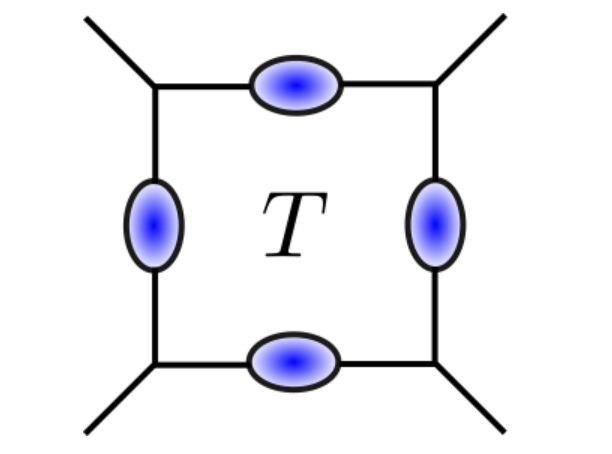

## Exercice 0
complete the contraction

In [2]:
def local_tensor_T(beta, h):
#H =- s s -h s
    Boltz_weight=np.zeros([2,2])
    for s_1 in [0,1]:
        for s_2 in [0,1]:
            sigma_1=2.*(s_1-0.5)
            sigma_2=2.*(s_2-0.5)
            Boltz_weight[s_1,s_2]=(np.exp(beta*sigma_1*sigma_2+
                                               beta*h*0.5*(sigma_1+sigma_2)))    

    
    
    copy_3= np.zeros([2,2,2])
    #copy_4= np.zeros([2,2,2,2])
    
    for s in [0,1]:
        copy_3[s,s,s]=1.
        #copy_4[s,s,s,s]=1.
    
    list_tensors =[copy_3,
                   Boltz_weight,
                   copy_3,
                   Boltz_weight,
                   copy_3,
                   Boltz_weight,
                   copy_3,
                   Boltz_weight]    
    list_indices =[[],[],[],[],
                    [],[],[],[]]
    tensor_z_two_dim = ncon(list_tensors,list_indices)
    return tensor_z_two_dim

## Multiplying the infinite transfer matrix 



Now  we need to code the two functions that perform the contraction of the partition function and the numerator for the magnetization, 
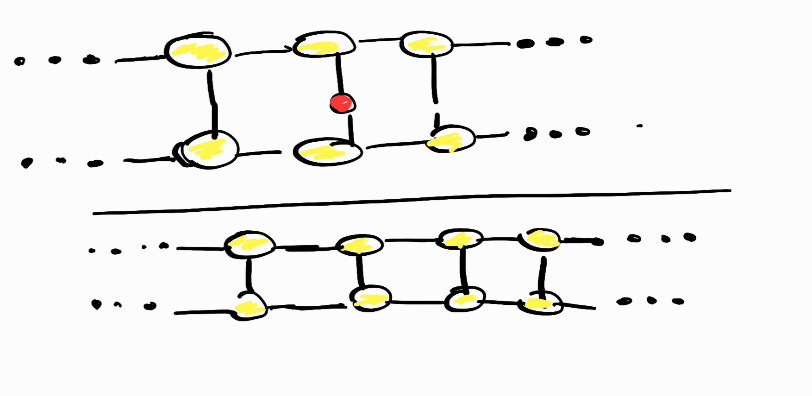

*** In this plot

the MPS matrices are found as the fixed point of the tranfer matrix operator defined in terms of the $$T$$ tensors above

![](../pictures/eig_equation.png)


Notice that the local red tensor is just a $$\sigma_z$$ operator, that allows us to compute the local magnetization since

$$<\sigma_R> =\frac{\sum_{\{\sigma\}}\sigma_R \exp[-{\beta H}]}{Z}$$


The problem is thus 
***GIVEN T*** find ***A*** where ***A*** is the three leg tensor. 

## In the canonical form 
When the MPS is in the canonical form the above contraction becomes
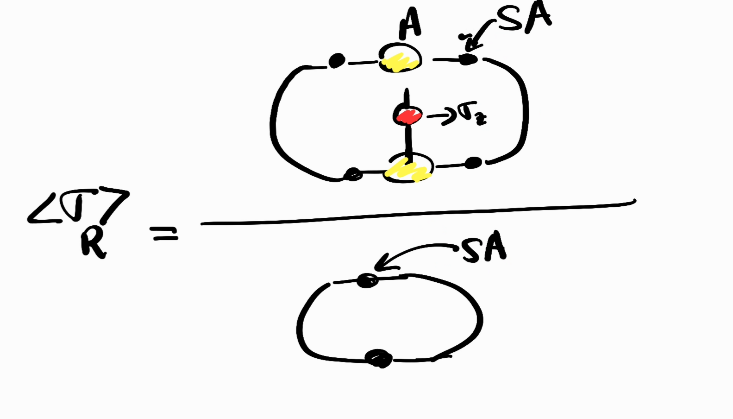





## Exercise 1 
Fill the missing lines in the code to provide the correct tensor contractions for both numerator and denominator of the calculation of the magnetization (the tensor networks in the previous drawing). 

The ordering of the legs for the tensors is given in the figure and all $C$ and all $T$ are the same. 

![](../pictures/bc_ingredients_ord.png)

In [3]:
def compute_norm_and_mag(A,sA,Op):
    numerator = ncon([np.diag(sA**2),A,np.diag(sA**2),A.conj(),Op],
                   [[],[],[],[],[]]
                    )
    norm = ncon([np.diag(sA**2),A,np.diag(sA**2),A.conj(),np.eye(2)],
                              [[],[],[],[],[]])
    
    return(numerator, norm)

## One step

Now the core of the boundary contraction method is to find the fixed point of the transformation 

![](../pictures/local_tn.png)
$$\chi \le \chi_{max}$$




In order to do that we first need to absorb the $$T$$ tensor into the $$A$$ tensor




## Exercice two complete the code

The function should abosrb one $$T$$ tensor into each $$A$$ tensor. 

In [4]:
def contract_T_MPS(MPS,MPO):
     d = MPS.shape[1]
     chi = MPS.shape[0]
     list_tensor=[MPS,MPO]
     list_indices =[[],[]]
     AO =ncon(list_tensor,list_indices).reshape(d*chi,d,d*chi)
     return AO


 ## Going to the canonical representation
 
Now in order to truncate the larger bond of the $$A$$ tensor in a meaningful way, we need to go the canonical representation. 
This requires 
 1. finding the leading vectors (right and left)  of the MPS transfer matrix,
 2. setting them to the identity using a gauge transformation $X X^{-1}$,
 $Y Y^{-1}$
 3. Performing a singular value  the resulting link matrix $Xs_AY$ and reabsorbing the unitaries on both sides
 
 ***NOTICE*** that in step 3. we will directly truncate to a maximal bond dimension $\chi_{max}$ by keeping only the largest $\chi_max$ singular values 
 At the end this was all the reason to go to the canoncial gauge. 
 
 The first step is performed by the following function 
 
 ## Exercice 3 complete the TN contraction

In [5]:
def eig_TM_A(A):
    chi = A.shape[0]
    v0 =np.random.rand(chi*chi)
    def mult_tm_left(v0):
        chi = A.shape[0]
        v0 =ncon([A,A.conj(),v0.reshape(chi,chi)],
                 [[],[],[]])
        
        return v0.reshape(chi*chi)
    def mult_tm_right(v0):
         chi = A.shape[0]
         v0 =ncon([A,A.conj(),v0.reshape(chi,chi)],
                  [[],[],[]])
         return v0.reshape(chi*chi)
     
         
    e_L, L = eigs(LinearOperator((chi**2, chi**2), 
                                 matvec=mult_tm_left),
                        k=1, which='LM', v0=v0, tol=1e-10)
    e_R, R = eigs(LinearOperator((chi**2, chi**2), 
                                 matvec=mult_tm_right),
                        k=1, which='LM', v0=v0, tol=1e-10)
    R = R.reshape(chi,chi)
    L = L.reshape(chi,chi)
    #print(np.sum(L-L.T.conj()))
    #print(np.sum(R-R.T.conj()))
    L = 0.5*(L+L.T.conj())/(np.trace(L)/np.abs(np.trace(L)))
    R = 0.5*(R+R.T.conj())/(np.trace(R)/np.abs(np.trace(R)))
    A =A/np.sqrt(e_L)
    return(L,R,A)
            

 Step 2 & 3 are performed by the following function
 
 
 

In [6]:
def orthogonalize_A(L,R,A,sA,dtol=1.e-12,max_chi=16):
    # diagonalize left environment matrix

    dtemp, utemp = LA.eigh(L)
    chitemp = sum(dtemp > dtol)
    chitemp =min(chitemp,max_chi) 
    DL = dtemp[range(-1, -chitemp - 1, -1)]
    UL = utemp[:, range(-1, -chitemp - 1, -1)]

    # diagonalize right environment matrix
    dtemp, utemp = LA.eigh(R)
    chitemp = sum(dtemp > dtol)
    chitemp =min(chitemp,max_chi) 
    DR = dtemp[range(-1, -chitemp - 1, -1)]
    UR = utemp[:, range(-1, -chitemp - 1, -1)]
    weighted_mat = (np.diag(np.sqrt(DL)) @ UL.T @ np.diag(sA)
                    @ UR @ np.diag(np.sqrt(DR)))
    
    UA, stemp, VhA = LA.svd(weighted_mat, full_matrices=False)
    sA = stemp / LA.norm(stemp)
    x = np.conj(UL) @ np.diag(1 / np.sqrt(DL)) @ UA
    y = np.conj(UR) @ np.diag(1 / np.sqrt(DR)) @ VhA.T
    A = ncon([y, A], [[1, -1], [1, -2, -3]])
    A = ncon([A, x], [[-1, -2, 2], [2, -3]])
    return A, sA

In order to compare with the exact result we need to compute also the exact magnetization for $\beta\ge \beta_c$ given by 
$$M = \left[ 1 - \sinh^{-4}(2 \beta) \right]^{1/8}$$ 



In [7]:


def exact_mag(beta):
    return (1 - np.sinh(2*beta)**(-4))**(1/8)

## Now we put it all together


Now we can put all together, since the boundary contraction is an iterative method one should take care about the convergence, by e.g. tracking the magnetization and repeating the algorithm untill it stop changing (up to a desired accuracy). For simplicity here we will fix the number of iteration to 100 and run the program for different $\beta$. 

In [ ]:
max_chi=4
dtol = 1.e-10
numiter=200
list_mag=[]
b_start=0.42
b_fin =0.48
b_steps =50
x= np.linspace(b_start,b_fin,b_steps)
Op=np.array([[1,0],[0,-1]])
for beta in x:
    T= local_tensor_T(beta, h)
    A = T[:,:,0,:]
  
    sA = np.ones(A.shape[0])
    
    for k in range(numiter+1):
        #absorb the weight
        A = ncon([np.diag(np.sqrt(sA)),A,np.diag(np.sqrt(sA))],[[-1,2],
                                        [2,-2,1],[1,-3]])
        AT = contract_T_MPS(A,T)
        chi_A =AT.shape[0]
        #print(chi_A)
        L,R,AT =eig_TM_A(AT)
        #print(ncon([L,AT,R,AT.conj()],[[1,5],[1,4,2],[2,3],[5,4,3]]))
        A ,sA = orthogonalize_A(L,R,AT,np.ones(chi_A),dtol,max_chi)
        mag = ncon([np.diag(sA**2),A,np.diag(sA**2),A.conj(),Op],
                   [[4,1],[1,5,2],[2,3],[4,6,3],[5,6]]
                    )
        norm = ncon([np.diag(sA**2),A,np.diag(sA**2),A.conj(),np.eye(2)],
                              [[4,1],[1,5,2],[2,3],[4,6,3],[5,6]])
             
        print('Beta :%g, ite %d: Mag :%g, Norm: %g, Chi :%d'%(beta, k, 
                                                              np.real_if_close(mag),
                                                              np.real_if_close(norm), chi_A))
    
    list_mag.append(mag)

Beta :0.42, ite 0: Mag :0.812943, Norm: 1.00486, Chi :4
Beta :0.42, ite 1: Mag :0.740828, Norm: 1, Chi :8
Beta :0.42, ite 2: Mag :0.684945, Norm: 1, Chi :8
Beta :0.42, ite 3: Mag :0.635433, Norm: 1, Chi :8
Beta :0.42, ite 4: Mag :0.589695, Norm: 1, Chi :8
Beta :0.42, ite 5: Mag :0.546495, Norm: 1, Chi :8
Beta :0.42, ite 6: Mag :0.505255, Norm: 1, Chi :8
Beta :0.42, ite 7: Mag :0.465745, Norm: 1, Chi :8
Beta :0.42, ite 8: Mag :0.427927, Norm: 1, Chi :8
Beta :0.42, ite 9: Mag :0.391864, Norm: 1, Chi :8
Beta :0.42, ite 10: Mag :0.357657, Norm: 1, Chi :8
Beta :0.42, ite 11: Mag :0.325412, Norm: 1, Chi :8
Beta :0.42, ite 12: Mag :0.295214, Norm: 1, Chi :8
Beta :0.42, ite 13: Mag :0.267112, Norm: 1, Chi :8
Beta :0.42, ite 14: Mag :0.241117, Norm: 1, Chi :8
Beta :0.42, ite 15: Mag :0.217205, Norm: 1, Chi :8
Beta :0.42, ite 16: Mag :0.195315, Norm: 1, Chi :8
Beta :0.42, ite 17: Mag :0.175364, Norm: 1, Chi :8
Beta :0.42, ite 18: Mag :0.157249, Norm: 1, Chi :8
Beta :0.42, ite 19: Mag :0.140853, 

Beta :0.42, ite 157: Mag :1.84228e-08, Norm: 1, Chi :8
Beta :0.42, ite 158: Mag :1.64214e-08, Norm: 1, Chi :8
Beta :0.42, ite 159: Mag :1.46374e-08, Norm: 1, Chi :8
Beta :0.42, ite 160: Mag :1.30473e-08, Norm: 1, Chi :8
Beta :0.42, ite 161: Mag :1.16299e-08, Norm: 1, Chi :8
Beta :0.42, ite 162: Mag :1.03665e-08, Norm: 1, Chi :8
Beta :0.42, ite 163: Mag :9.24033e-09, Norm: 1, Chi :8
Beta :0.42, ite 164: Mag :8.23659e-09, Norm: 1, Chi :8
Beta :0.42, ite 165: Mag :7.34178e-09, Norm: 1, Chi :8
Beta :0.42, ite 166: Mag :6.5442e-09, Norm: 1, Chi :8
Beta :0.42, ite 167: Mag :5.83318e-09, Norm: 1, Chi :8
Beta :0.42, ite 168: Mag :5.19949e-09, Norm: 1, Chi :8
Beta :0.42, ite 169: Mag :4.63454e-09, Norm: 1, Chi :8
Beta :0.42, ite 170: Mag :4.13109e-09, Norm: 1, Chi :8
Beta :0.42, ite 171: Mag :3.68231e-09, Norm: 1, Chi :8
Beta :0.42, ite 172: Mag :3.28238e-09, Norm: 1, Chi :8
Beta :0.42, ite 173: Mag :2.92576e-09, Norm: 1, Chi :8
Beta :0.42, ite 174: Mag :2.60792e-09, Norm: 1, Chi :8
Beta :0.42,

Beta :0.421224, ite 113: Mag :6.67528e-06, Norm: 1, Chi :8
Beta :0.421224, ite 114: Mag :5.99415e-06, Norm: 1, Chi :8
Beta :0.421224, ite 115: Mag :5.38252e-06, Norm: 1, Chi :8
Beta :0.421224, ite 116: Mag :4.8333e-06, Norm: 1, Chi :8
Beta :0.421224, ite 117: Mag :4.34013e-06, Norm: 1, Chi :8
Beta :0.421224, ite 118: Mag :3.89727e-06, Norm: 1, Chi :8
Beta :0.421224, ite 119: Mag :3.4996e-06, Norm: 1, Chi :8
Beta :0.421224, ite 120: Mag :3.14251e-06, Norm: 1, Chi :8
Beta :0.421224, ite 121: Mag :2.82186e-06, Norm: 1, Chi :8
Beta :0.421224, ite 122: Mag :2.53392e-06, Norm: 1, Chi :8
Beta :0.421224, ite 123: Mag :2.27537e-06, Norm: 1, Chi :8
Beta :0.421224, ite 124: Mag :2.04319e-06, Norm: 1, Chi :8
Beta :0.421224, ite 125: Mag :1.83471e-06, Norm: 1, Chi :8
Beta :0.421224, ite 126: Mag :1.6475e-06, Norm: 1, Chi :8
Beta :0.421224, ite 127: Mag :1.47939e-06, Norm: 1, Chi :8
Beta :0.421224, ite 128: Mag :1.32844e-06, Norm: 1, Chi :8
Beta :0.421224, ite 129: Mag :1.19289e-06, Norm: 1, Chi :8


Beta :0.422449, ite 69: Mag :0.0012626, Norm: 1, Chi :8
Beta :0.422449, ite 70: Mag :0.00114217, Norm: 1, Chi :8
Beta :0.422449, ite 71: Mag :0.00103322, Norm: 1, Chi :8
Beta :0.422449, ite 72: Mag :0.00093467, Norm: 1, Chi :8
Beta :0.422449, ite 73: Mag :0.000845517, Norm: 1, Chi :8
Beta :0.422449, ite 74: Mag :0.000764867, Norm: 1, Chi :8
Beta :0.422449, ite 75: Mag :0.00069191, Norm: 1, Chi :8
Beta :0.422449, ite 76: Mag :0.000625912, Norm: 1, Chi :8
Beta :0.422449, ite 77: Mag :0.000566209, Norm: 1, Chi :8
Beta :0.422449, ite 78: Mag :0.000512201, Norm: 1, Chi :8
Beta :0.422449, ite 79: Mag :0.000463344, Norm: 1, Chi :8
Beta :0.422449, ite 80: Mag :0.000419148, Norm: 1, Chi :8
Beta :0.422449, ite 81: Mag :0.000379167, Norm: 1, Chi :8
Beta :0.422449, ite 82: Mag :0.000343, Norm: 1, Chi :8
Beta :0.422449, ite 83: Mag :0.000310283, Norm: 1, Chi :8
Beta :0.422449, ite 84: Mag :0.000280687, Norm: 1, Chi :8
Beta :0.422449, ite 85: Mag :0.000253913, Norm: 1, Chi :8
Beta :0.422449, ite 86:

Beta :0.423673, ite 18: Mag :0.226488, Norm: 1, Chi :8
Beta :0.423673, ite 19: Mag :0.208033, Norm: 1, Chi :8
Beta :0.423673, ite 20: Mag :0.19087, Norm: 1, Chi :8
Beta :0.423673, ite 21: Mag :0.174954, Norm: 1, Chi :8
Beta :0.423673, ite 22: Mag :0.160229, Norm: 1, Chi :8
Beta :0.423673, ite 23: Mag :0.146635, Norm: 1, Chi :8
Beta :0.423673, ite 24: Mag :0.13411, Norm: 1, Chi :8
Beta :0.423673, ite 25: Mag :0.122587, Norm: 1, Chi :8
Beta :0.423673, ite 26: Mag :0.112002, Norm: 1, Chi :8
Beta :0.423673, ite 27: Mag :0.10229, Norm: 1, Chi :8
Beta :0.423673, ite 28: Mag :0.0933881, Norm: 1, Chi :8
Beta :0.423673, ite 29: Mag :0.0852366, Norm: 1, Chi :8
Beta :0.423673, ite 30: Mag :0.0777775, Norm: 1, Chi :8
Beta :0.423673, ite 31: Mag :0.0709566, Norm: 1, Chi :8
Beta :0.423673, ite 32: Mag :0.0647225, Norm: 1, Chi :8
Beta :0.423673, ite 33: Mag :0.0590276, Norm: 1, Chi :8
Beta :0.423673, ite 34: Mag :0.0538271, Norm: 1, Chi :8
Beta :0.423673, ite 35: Mag :0.0490797, Norm: 1, Chi :8
Beta 

Beta :0.423673, ite 166: Mag :2.56534e-07, Norm: 1, Chi :8
Beta :0.423673, ite 167: Mag :2.33785e-07, Norm: 1, Chi :8
Beta :0.423673, ite 168: Mag :2.13054e-07, Norm: 1, Chi :8
Beta :0.423673, ite 169: Mag :1.94161e-07, Norm: 1, Chi :8
Beta :0.423673, ite 170: Mag :1.76943e-07, Norm: 1, Chi :8
Beta :0.423673, ite 171: Mag :1.61253e-07, Norm: 1, Chi :8
Beta :0.423673, ite 172: Mag :1.46953e-07, Norm: 1, Chi :8
Beta :0.423673, ite 173: Mag :1.33922e-07, Norm: 1, Chi :8
Beta :0.423673, ite 174: Mag :1.22046e-07, Norm: 1, Chi :8
Beta :0.423673, ite 175: Mag :1.11224e-07, Norm: 1, Chi :8
Beta :0.423673, ite 176: Mag :1.01361e-07, Norm: 1, Chi :8
Beta :0.423673, ite 177: Mag :9.23723e-08, Norm: 1, Chi :8
Beta :0.423673, ite 178: Mag :8.41811e-08, Norm: 1, Chi :8
Beta :0.423673, ite 179: Mag :7.67161e-08, Norm: 1, Chi :8
Beta :0.423673, ite 180: Mag :6.99132e-08, Norm: 1, Chi :8
Beta :0.423673, ite 181: Mag :6.37135e-08, Norm: 1, Chi :8
Beta :0.423673, ite 182: Mag :5.80636e-08, Norm: 1, Chi 

Beta :0.424898, ite 116: Mag :6.2461e-05, Norm: 1, Chi :8
Beta :0.424898, ite 117: Mag :5.73449e-05, Norm: 1, Chi :8
Beta :0.424898, ite 118: Mag :5.26479e-05, Norm: 1, Chi :8
Beta :0.424898, ite 119: Mag :4.83356e-05, Norm: 1, Chi :8
Beta :0.424898, ite 120: Mag :4.43765e-05, Norm: 1, Chi :8
Beta :0.424898, ite 121: Mag :4.07417e-05, Norm: 1, Chi :8
Beta :0.424898, ite 122: Mag :3.74046e-05, Norm: 1, Chi :8
Beta :0.424898, ite 123: Mag :3.43409e-05, Norm: 1, Chi :8
Beta :0.424898, ite 124: Mag :3.15281e-05, Norm: 1, Chi :8
Beta :0.424898, ite 125: Mag :2.89457e-05, Norm: 1, Chi :8
Beta :0.424898, ite 126: Mag :2.65748e-05, Norm: 1, Chi :8
Beta :0.424898, ite 127: Mag :2.43981e-05, Norm: 1, Chi :8
Beta :0.424898, ite 128: Mag :2.23997e-05, Norm: 1, Chi :8
Beta :0.424898, ite 129: Mag :2.0565e-05, Norm: 1, Chi :8
Beta :0.424898, ite 130: Mag :1.88805e-05, Norm: 1, Chi :8
Beta :0.424898, ite 131: Mag :1.73341e-05, Norm: 1, Chi :8
Beta :0.424898, ite 132: Mag :1.59143e-05, Norm: 1, Chi :8

Beta :0.426122, ite 61: Mag :0.0107006, Norm: 1, Chi :8
Beta :0.426122, ite 62: Mag :0.00989738, Norm: 1, Chi :8
Beta :0.426122, ite 63: Mag :0.00915446, Norm: 1, Chi :8
Beta :0.426122, ite 64: Mag :0.00846729, Norm: 1, Chi :8
Beta :0.426122, ite 65: Mag :0.00783168, Norm: 1, Chi :8
Beta :0.426122, ite 66: Mag :0.00724377, Norm: 1, Chi :8
Beta :0.426122, ite 67: Mag :0.00669999, Norm: 1, Chi :8
Beta :0.426122, ite 68: Mag :0.00619702, Norm: 1, Chi :8
Beta :0.426122, ite 69: Mag :0.0057318, Norm: 1, Chi :8
Beta :0.426122, ite 70: Mag :0.00530151, Norm: 1, Chi :8
Beta :0.426122, ite 71: Mag :0.00490351, Norm: 1, Chi :8
Beta :0.426122, ite 72: Mag :0.00453539, Norm: 1, Chi :8
Beta :0.426122, ite 73: Mag :0.0041949, Norm: 1, Chi :8
Beta :0.426122, ite 74: Mag :0.00387997, Norm: 1, Chi :8
Beta :0.426122, ite 75: Mag :0.00358868, Norm: 1, Chi :8
Beta :0.426122, ite 76: Mag :0.00331926, Norm: 1, Chi :8
Beta :0.426122, ite 77: Mag :0.00307007, Norm: 1, Chi :8
Beta :0.426122, ite 78: Mag :0.002

Beta :0.427347, ite 5: Mag :0.620487, Norm: 1, Chi :8
Beta :0.427347, ite 6: Mag :0.591482, Norm: 1, Chi :8
Beta :0.427347, ite 7: Mag :0.563888, Norm: 1, Chi :8
Beta :0.427347, ite 8: Mag :0.537395, Norm: 1, Chi :8
Beta :0.427347, ite 9: Mag :0.511812, Norm: 1, Chi :8
Beta :0.427347, ite 10: Mag :0.487024, Norm: 1, Chi :8
Beta :0.427347, ite 11: Mag :0.462965, Norm: 1, Chi :8
Beta :0.427347, ite 12: Mag :0.439603, Norm: 1, Chi :8
Beta :0.427347, ite 13: Mag :0.416928, Norm: 1, Chi :8
Beta :0.427347, ite 14: Mag :0.394945, Norm: 1, Chi :8
Beta :0.427347, ite 15: Mag :0.373669, Norm: 1, Chi :8
Beta :0.427347, ite 16: Mag :0.353116, Norm: 1, Chi :8
Beta :0.427347, ite 17: Mag :0.333306, Norm: 1, Chi :8
Beta :0.427347, ite 18: Mag :0.314255, Norm: 1, Chi :8
Beta :0.427347, ite 19: Mag :0.295978, Norm: 1, Chi :8
Beta :0.427347, ite 20: Mag :0.278483, Norm: 1, Chi :8
Beta :0.427347, ite 21: Mag :0.261775, Norm: 1, Chi :8
Beta :0.427347, ite 22: Mag :0.245854, Norm: 1, Chi :8
Beta :0.427347,

Beta :0.427347, ite 150: Mag :3.10266e-05, Norm: 1, Chi :8
Beta :0.427347, ite 151: Mag :2.89113e-05, Norm: 1, Chi :8
Beta :0.427347, ite 152: Mag :2.69402e-05, Norm: 1, Chi :8
Beta :0.427347, ite 153: Mag :2.51034e-05, Norm: 1, Chi :8
Beta :0.427347, ite 154: Mag :2.33919e-05, Norm: 1, Chi :8
Beta :0.427347, ite 155: Mag :2.17971e-05, Norm: 1, Chi :8
Beta :0.427347, ite 156: Mag :2.0311e-05, Norm: 1, Chi :8
Beta :0.427347, ite 157: Mag :1.89262e-05, Norm: 1, Chi :8
Beta :0.427347, ite 158: Mag :1.76359e-05, Norm: 1, Chi :8
Beta :0.427347, ite 159: Mag :1.64335e-05, Norm: 1, Chi :8
Beta :0.427347, ite 160: Mag :1.53131e-05, Norm: 1, Chi :8
Beta :0.427347, ite 161: Mag :1.42691e-05, Norm: 1, Chi :8
Beta :0.427347, ite 162: Mag :1.32962e-05, Norm: 1, Chi :8
Beta :0.427347, ite 163: Mag :1.23897e-05, Norm: 1, Chi :8
Beta :0.427347, ite 164: Mag :1.1545e-05, Norm: 1, Chi :8
Beta :0.427347, ite 165: Mag :1.07579e-05, Norm: 1, Chi :8
Beta :0.427347, ite 166: Mag :1.00244e-05, Norm: 1, Chi :8

Beta :0.428571, ite 111: Mag :0.00109658, Norm: 1, Chi :8
Beta :0.428571, ite 112: Mag :0.00102946, Norm: 1, Chi :8
Beta :0.428571, ite 113: Mag :0.000966445, Norm: 1, Chi :8
Beta :0.428571, ite 114: Mag :0.000907291, Norm: 1, Chi :8
Beta :0.428571, ite 115: Mag :0.000851757, Norm: 1, Chi :8
Beta :0.428571, ite 116: Mag :0.000799622, Norm: 1, Chi :8
Beta :0.428571, ite 117: Mag :0.000750679, Norm: 1, Chi :8
Beta :0.428571, ite 118: Mag :0.000704731, Norm: 1, Chi :8
Beta :0.428571, ite 119: Mag :0.000661595, Norm: 1, Chi :8
Beta :0.428571, ite 120: Mag :0.0006211, Norm: 1, Chi :8
Beta :0.428571, ite 121: Mag :0.000583084, Norm: 1, Chi :8
Beta :0.428571, ite 122: Mag :0.000547394, Norm: 1, Chi :8
Beta :0.428571, ite 123: Mag :0.000513889, Norm: 1, Chi :8
Beta :0.428571, ite 124: Mag :0.000482435, Norm: 1, Chi :8
Beta :0.428571, ite 125: Mag :0.000452905, Norm: 1, Chi :8
Beta :0.428571, ite 126: Mag :0.000425184, Norm: 1, Chi :8
Beta :0.428571, ite 127: Mag :0.000399159, Norm: 1, Chi :8
B

Beta :0.429796, ite 53: Mag :0.0619666, Norm: 1, Chi :8
Beta :0.429796, ite 54: Mag :0.0586349, Norm: 1, Chi :8
Beta :0.429796, ite 55: Mag :0.05548, Norm: 1, Chi :8
Beta :0.429796, ite 56: Mag :0.0524928, Norm: 1, Chi :8
Beta :0.429796, ite 57: Mag :0.0496647, Norm: 1, Chi :8
Beta :0.429796, ite 58: Mag :0.0469875, Norm: 1, Chi :8
Beta :0.429796, ite 59: Mag :0.0444534, Norm: 1, Chi :8
Beta :0.429796, ite 60: Mag :0.0420549, Norm: 1, Chi :8
Beta :0.429796, ite 61: Mag :0.0397849, Norm: 1, Chi :8
Beta :0.429796, ite 62: Mag :0.0376367, Norm: 1, Chi :8
Beta :0.429796, ite 63: Mag :0.0356038, Norm: 1, Chi :8
Beta :0.429796, ite 64: Mag :0.0336802, Norm: 1, Chi :8
Beta :0.429796, ite 65: Mag :0.0318601, Norm: 1, Chi :8
Beta :0.429796, ite 66: Mag :0.0301379, Norm: 1, Chi :8
Beta :0.429796, ite 67: Mag :0.0285084, Norm: 1, Chi :8
Beta :0.429796, ite 68: Mag :0.0269668, Norm: 1, Chi :8
Beta :0.429796, ite 69: Mag :0.0255083, Norm: 1, Chi :8
Beta :0.429796, ite 70: Mag :0.0241285, Norm: 1, C

Beta :0.43102, ite 11: Mag :0.530239, Norm: 1, Chi :8
Beta :0.43102, ite 12: Mag :0.512315, Norm: 1, Chi :8
Beta :0.43102, ite 13: Mag :0.494869, Norm: 1, Chi :8
Beta :0.43102, ite 14: Mag :0.477855, Norm: 1, Chi :8
Beta :0.43102, ite 15: Mag :0.461244, Norm: 1, Chi :8
Beta :0.43102, ite 16: Mag :0.445013, Norm: 1, Chi :8
Beta :0.43102, ite 17: Mag :0.42915, Norm: 1, Chi :8
Beta :0.43102, ite 18: Mag :0.413646, Norm: 1, Chi :8
Beta :0.43102, ite 19: Mag :0.398497, Norm: 1, Chi :8
Beta :0.43102, ite 20: Mag :0.383702, Norm: 1, Chi :8
Beta :0.43102, ite 21: Mag :0.369262, Norm: 1, Chi :8
Beta :0.43102, ite 22: Mag :0.355179, Norm: 1, Chi :8
Beta :0.43102, ite 23: Mag :0.341457, Norm: 1, Chi :8
Beta :0.43102, ite 24: Mag :0.328098, Norm: 1, Chi :8
Beta :0.43102, ite 25: Mag :0.315105, Norm: 1, Chi :8
Beta :0.43102, ite 26: Mag :0.302481, Norm: 1, Chi :8
Beta :0.43102, ite 27: Mag :0.290227, Norm: 1, Chi :8
Beta :0.43102, ite 28: Mag :0.278346, Norm: 1, Chi :8
Beta :0.43102, ite 29: Mag :0

Beta :0.43102, ite 171: Mag :0.000306047, Norm: 1, Chi :8
Beta :0.43102, ite 172: Mag :0.000291654, Norm: 1, Chi :8
Beta :0.43102, ite 173: Mag :0.000277937, Norm: 1, Chi :8
Beta :0.43102, ite 174: Mag :0.000264866, Norm: 1, Chi :8
Beta :0.43102, ite 175: Mag :0.000252409, Norm: 1, Chi :8
Beta :0.43102, ite 176: Mag :0.000240538, Norm: 1, Chi :8
Beta :0.43102, ite 177: Mag :0.000229226, Norm: 1, Chi :8
Beta :0.43102, ite 178: Mag :0.000218445, Norm: 1, Chi :8
Beta :0.43102, ite 179: Mag :0.000208172, Norm: 1, Chi :8
Beta :0.43102, ite 180: Mag :0.000198382, Norm: 1, Chi :8
Beta :0.43102, ite 181: Mag :0.000189052, Norm: 1, Chi :8
Beta :0.43102, ite 182: Mag :0.000180161, Norm: 1, Chi :8
Beta :0.43102, ite 183: Mag :0.000171688, Norm: 1, Chi :8
Beta :0.43102, ite 184: Mag :0.000163613, Norm: 1, Chi :8
Beta :0.43102, ite 185: Mag :0.000155918, Norm: 1, Chi :8
Beta :0.43102, ite 186: Mag :0.000148586, Norm: 1, Chi :8
Beta :0.43102, ite 187: Mag :0.000141598, Norm: 1, Chi :8
Beta :0.43102,

Beta :0.432245, ite 132: Mag :0.00522269, Norm: 1, Chi :8
Beta :0.432245, ite 133: Mag :0.0050148, Norm: 1, Chi :8
Beta :0.432245, ite 134: Mag :0.00481519, Norm: 1, Chi :8
Beta :0.432245, ite 135: Mag :0.00462352, Norm: 1, Chi :8
Beta :0.432245, ite 136: Mag :0.00443948, Norm: 1, Chi :8
Beta :0.432245, ite 137: Mag :0.00426277, Norm: 1, Chi :8
Beta :0.432245, ite 138: Mag :0.00409309, Norm: 1, Chi :8
Beta :0.432245, ite 139: Mag :0.00393016, Norm: 1, Chi :8
Beta :0.432245, ite 140: Mag :0.00377372, Norm: 1, Chi :8
Beta :0.432245, ite 141: Mag :0.0036235, Norm: 1, Chi :8
Beta :0.432245, ite 142: Mag :0.00347927, Norm: 1, Chi :8
Beta :0.432245, ite 143: Mag :0.00334077, Norm: 1, Chi :8
Beta :0.432245, ite 144: Mag :0.00320779, Norm: 1, Chi :8
Beta :0.432245, ite 145: Mag :0.0030801, Norm: 1, Chi :8
Beta :0.432245, ite 146: Mag :0.0029575, Norm: 1, Chi :8
Beta :0.432245, ite 147: Mag :0.00283977, Norm: 1, Chi :8
Beta :0.432245, ite 148: Mag :0.00272673, Norm: 1, Chi :8
Beta :0.432245, it

Beta :0.433469, ite 92: Mag :0.0504744, Norm: 1, Chi :8
Beta :0.433469, ite 93: Mag :0.0488426, Norm: 1, Chi :8
Beta :0.433469, ite 94: Mag :0.0472631, Norm: 1, Chi :8
Beta :0.433469, ite 95: Mag :0.0457342, Norm: 1, Chi :8
Beta :0.433469, ite 96: Mag :0.0442544, Norm: 1, Chi :8
Beta :0.433469, ite 97: Mag :0.0428221, Norm: 1, Chi :8
Beta :0.433469, ite 98: Mag :0.0414359, Norm: 1, Chi :8
Beta :0.433469, ite 99: Mag :0.0400943, Norm: 1, Chi :8
Beta :0.433469, ite 100: Mag :0.0387959, Norm: 1, Chi :8
Beta :0.433469, ite 101: Mag :0.0375392, Norm: 1, Chi :8
Beta :0.433469, ite 102: Mag :0.0363231, Norm: 1, Chi :8
Beta :0.433469, ite 103: Mag :0.0351461, Norm: 1, Chi :8
Beta :0.433469, ite 104: Mag :0.0340072, Norm: 1, Chi :8
Beta :0.433469, ite 105: Mag :0.0329049, Norm: 1, Chi :8
Beta :0.433469, ite 106: Mag :0.0318383, Norm: 1, Chi :8
Beta :0.433469, ite 107: Mag :0.0308061, Norm: 1, Chi :8
Beta :0.433469, ite 108: Mag :0.0298072, Norm: 1, Chi :8
Beta :0.433469, ite 109: Mag :0.0288407

Beta :0.434694, ite 50: Mag :0.259565, Norm: 1, Chi :8
Beta :0.434694, ite 51: Mag :0.253697, Norm: 1, Chi :8
Beta :0.434694, ite 52: Mag :0.247938, Norm: 1, Chi :8
Beta :0.434694, ite 53: Mag :0.242288, Norm: 1, Chi :8
Beta :0.434694, ite 54: Mag :0.236746, Norm: 1, Chi :8
Beta :0.434694, ite 55: Mag :0.231311, Norm: 1, Chi :8
Beta :0.434694, ite 56: Mag :0.225982, Norm: 1, Chi :8
Beta :0.434694, ite 57: Mag :0.220757, Norm: 1, Chi :8
Beta :0.434694, ite 58: Mag :0.215637, Norm: 1, Chi :8
Beta :0.434694, ite 59: Mag :0.210619, Norm: 1, Chi :8
Beta :0.434694, ite 60: Mag :0.205703, Norm: 1, Chi :8
Beta :0.434694, ite 61: Mag :0.200887, Norm: 1, Chi :8
Beta :0.434694, ite 62: Mag :0.19617, Norm: 1, Chi :8
Beta :0.434694, ite 63: Mag :0.191551, Norm: 1, Chi :8
Beta :0.434694, ite 64: Mag :0.187029, Norm: 1, Chi :8
Beta :0.434694, ite 65: Mag :0.182603, Norm: 1, Chi :8
Beta :0.434694, ite 66: Mag :0.17827, Norm: 1, Chi :8
Beta :0.434694, ite 67: Mag :0.17403, Norm: 1, Chi :8
Beta :0.43469

Beta :0.435918, ite 6: Mag :0.676502, Norm: 1, Chi :8
Beta :0.435918, ite 7: Mag :0.661121, Norm: 1, Chi :8
Beta :0.435918, ite 8: Mag :0.647003, Norm: 1, Chi :8
Beta :0.435918, ite 9: Mag :0.633896, Norm: 1, Chi :8
Beta :0.435918, ite 10: Mag :0.621616, Norm: 1, Chi :8
Beta :0.435918, ite 11: Mag :0.610024, Norm: 1, Chi :8
Beta :0.435918, ite 12: Mag :0.599016, Norm: 1, Chi :8
Beta :0.435918, ite 13: Mag :0.588507, Norm: 1, Chi :8
Beta :0.435918, ite 14: Mag :0.578431, Norm: 1, Chi :8
Beta :0.435918, ite 15: Mag :0.568735, Norm: 1, Chi :8
Beta :0.435918, ite 16: Mag :0.559375, Norm: 1, Chi :8
Beta :0.435918, ite 17: Mag :0.550315, Norm: 1, Chi :8
Beta :0.435918, ite 18: Mag :0.541523, Norm: 1, Chi :8
Beta :0.435918, ite 19: Mag :0.532975, Norm: 1, Chi :8
Beta :0.435918, ite 20: Mag :0.524647, Norm: 1, Chi :8
Beta :0.435918, ite 21: Mag :0.516523, Norm: 1, Chi :8
Beta :0.435918, ite 22: Mag :0.508585, Norm: 1, Chi :8
Beta :0.435918, ite 23: Mag :0.500819, Norm: 1, Chi :8
Beta :0.435918

Beta :0.435918, ite 158: Mag :0.0534647, Norm: 1, Chi :8
Beta :0.435918, ite 159: Mag :0.0525351, Norm: 1, Chi :8
Beta :0.435918, ite 160: Mag :0.0516215, Norm: 1, Chi :8
Beta :0.435918, ite 161: Mag :0.0507236, Norm: 1, Chi :8
Beta :0.435918, ite 162: Mag :0.0498412, Norm: 1, Chi :8
Beta :0.435918, ite 163: Mag :0.0489741, Norm: 1, Chi :8
Beta :0.435918, ite 164: Mag :0.048122, Norm: 1, Chi :8
Beta :0.435918, ite 165: Mag :0.0472845, Norm: 1, Chi :8
Beta :0.435918, ite 166: Mag :0.0464616, Norm: 1, Chi :8
Beta :0.435918, ite 167: Mag :0.0456529, Norm: 1, Chi :8
Beta :0.435918, ite 168: Mag :0.0448581, Norm: 1, Chi :8
Beta :0.435918, ite 169: Mag :0.0440772, Norm: 1, Chi :8
Beta :0.435918, ite 170: Mag :0.0433097, Norm: 1, Chi :8
Beta :0.435918, ite 171: Mag :0.0425555, Norm: 1, Chi :8
Beta :0.435918, ite 172: Mag :0.0418144, Norm: 1, Chi :8
Beta :0.435918, ite 173: Mag :0.0410861, Norm: 1, Chi :8
Beta :0.435918, ite 174: Mag :0.0403705, Norm: 1, Chi :8
Beta :0.435918, ite 175: Mag :0.



##  Exercise 4, The phase diagram
You can now collect the results of the magnetization and plot them as a function of the inverse temperature $\beta$, comparing (above the critical point) with the exact result. 